# Proje Tanıtımı: Entegre Memogram Görüntü Sınıflandırma Modeli

Bu proje, [CBIS-DDSM (Curated Breast Imaging Subset of Digital Database for Screening Mammography)](https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/data) veri setini kullanarak memogram görüntülerinin sınıflandırılması amacıyla geliştirilmiştir. Proje, VGG16 ve ResNet50V2 gibi iki farklı transfer learning modelini birleştirerek entegre bir model oluşturmayı hedeflemektedir. Bu iki güçlü derin öğrenme mimarisinin birleşimi, memogram görüntülerinden elde edilen özelliklerin daha etkin bir şekilde çıkarılmasını hedeflenmektedir.

Veri seti, farklı türde meme kanseri vakalarını içeren tam memogram görüntüleri içerir. Proje, bu görüntüleri işleyerek, her iki modelin önceden eğitilmiş ağırlıklarını kullanarak son katmanların çıkarılması ile öznitelik çıkarımı yapar. VGG16 modelinden ve ResNet50V2 modelinden elde edilen özellikler, global average pooling ile öznitelik vektörlerine dönüştürülür ve bu öznitelikler daha sonra birleştirilerek tam bağlantılı katmanlar üzerinde işlenir. Sonuç olarak, entegre model, ikili sınıflandırma problemini çözmek için eğitim verileri üzerinde eğitilir ve hem doğruluk hem de kayıp değerleri ile değerlendirilir.


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Gerekli kütüphanelerin import edilir.

In [38]:
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import Dense, Conv2D, Flatten , Dropout , BatchNormalization, MaxPooling2D, GlobalAveragePooling2D

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix


### Veri Ön İşleme Adımları

1. **Verilerin Okunması:**
   Veriler, belirtilen CSV dosyasından okunarak işlenmeye başlanır.

2. **Görsellerin Ölçeklendirilmesi:**
   Her bir görsel, `resize_with_padding` fonksiyonu kullanılarak 256x256 boyutlarına getirilir. Bu işlem, orijinal görselin oranlarını koruyarak yeniden boyutlandırma ve siyah kenarlarla padding ekleme işlemini içerir.

3. **Sol ve Sağ Meme Görsellerinin Kontrolü:**
   `left_or_right` fonksiyonu ile her bir görselin sol ya da sağ meme görseli olup olmadığı kontrol edilir. Eğer sağ meme görseli ise, görsel ayna simetrisi olacak şekilde çevrilir. Böylece tüm görseller aynı formata getirilir.

4. **Görselin Listeye Eklenmesi:**
   İşlenen her görsel, bir listeye eklenir.

5. **Etiketlerin Belirlenmesi:**
   Görsele karşılık gelen etiket, şu kurallara göre belirlenir:
   - Eğer görselin patoloji durumu "BENIGN" ya da "BENIGN_WITHOUT_CALLBACK" ise etiket 0 olarak belirlenir.
   - Eğer görselin patoloji durumu "Malignant" ise etiket 1 olarak belirlenir.


In [39]:
def resize_with_padding(image, target_size):
    # Orijinal boyutları al
    h, w = image.shape[:2]

    # Oranı koruyarak yeniden boyutlandırma
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Görüntüyü yeniden boyutlandırma
    resized_image = cv2.resize(image, (new_w, new_h))

    # Yatay ve dikey padding hesaplama
    delta_w = target_size[1] - new_w
    delta_h = target_size[0] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # Kenar dolgu ekleme (padding)
    color = [0, 0, 0]  # Siyah kenarlık
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

def left_or_right(img):
    height, width = img.shape[:2]

    # Görüntüyü ikiye bölme
    left_half = img[:, :width // 2]  # Sol yarı
    right_half = img[:, width // 2:]  # Sağ yarı

    # Piksel yoğunluklarını hesaplama (her bir pikselin parlaklık değerlerinin toplamı)
    left_intensity = np.sum(left_half)
    right_intensity = np.sum(right_half)

    if left_intensity > right_intensity:
        return img

    else:
        img = cv2.flip(img, 1)
        return img


# CSV dosyasının yolu
dosya_yolu = '/content/drive/MyDrive/Colab_Notebooks/cancer/archive/csv/mass_case_description_train_set.csv'

# CSV dosyasını oku
df = pd.read_csv(dosya_yolu)

rio = df.loc[df["image view"] == "CC", ["image file path", "pathology"]]
# Veriyi görüntüle
j = 0
img, label = [], []
for x, y in zip(rio["image file path"], rio["pathology"]):
    #print(f"Image File Path: {x}, Pathology: {y}")
    x = x.split('/')
    x = f"/content/drive/MyDrive/Colab_Notebooks/cancer/archive/jpeg/{x[2]}/*.jpg"
    x = glob.glob(x)
    x = cv2.imread(x[0])
    x = resize_with_padding(x, (256,256))
    #x = cv2.resize(x, (512,512))
    x = left_or_right(x)
    #cv2.imshow("winname", x)
    #cv2.waitKey(0)
    #x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x/255.0
    j+=1
    print(j)
    img.append(x)
    if y == "BENIGN" or y == "BENIGN_WITHOUT_CALLBACK":
        label.append(0)
    else:
        label.append(1)

dosya_yolu = '/content/drive/MyDrive/Colab_Notebooks/cancer/archive/csv/mass_case_description_test_set.csv'

# CSV dosyasını oku
df = pd.read_csv(dosya_yolu)

rio = df.loc[df["image view"] == "CC", ["image file path", "pathology"]]

for x, y in zip(rio["image file path"], rio["pathology"]):
    #print(f"Image File Path: {x}, Pathology: {y}")
    x = x.split('/')
    x = f"/content/drive/MyDrive/Colab_Notebooks/cancer/archive/jpeg/{x[2]}/*.jpg"
    x = glob.glob(x)
    x = cv2.imread(x[0])
    x = resize_with_padding(x, (256,256))
    #x = cv2.resize(x, (512,512))
    x = left_or_right(x)
    #cv2.imshow("winname", x)
    #cv2.waitKey(0)
    #x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x/255.0
    img.append(x)
    if y == "BENIGN" or y == "BENIGN_WITHOUT_CALLBACK":
        label.append(0)
    else:
        label.append(1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


### Veri Hazırlık Aşamaları (Kısaca)

1. **Verilerin NumPy Dizisine Dönüştürülmesi:**
   Görseller (`img`) ve etiketler (`label`), NumPy dizilerine dönüştürülür.
   
2. **Veri Setinin Eğitim ve Test Olarak Bölünmesi:**
   Veriler, %90 eğitim ve %10 test olacak şekilde ayrılır (`train_test_split` fonksiyonu ile).

3. **Veri Şeklinin Yeniden Boyutlandırılması:**
   Eğitim ve test verileri, 4 boyutlu olacak şekilde `(adet, yükseklik, genişlik, 3)` formatında yeniden şekillendirilir (RGB kanallarına sahip olacak şekilde).

In [40]:
img = np.array(img)
label = np.array(label)
class_size = 2
x_train, x_test, y_train, y_test  = train_test_split(img, label, test_size=0.1, random_state=42)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
#y_train = to_categorical(y_train, class_size)
#y_test = to_categorical(y_test, class_size)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(705, 256, 256, 3)
(79, 256, 256, 3)
(705,)
(79,)


# Model

Bu kodda iki farklı transfer learning modeli, **VGG16** ve **ResNet50V2**, kullanılarak entegre bir sınıflandırma modeli oluşturulmuştur. Her iki modelin önceden eğitilmiş ağırlıkları kullanılarak, son katmanlar hariç tutulmuş ve bu ağırlıklar dondurulmuştur. Giriş katmanı her iki model için aynı olup, giriş görüntüleri (256x256x3) boyutundadır.

**ResNet50V2** ve **VGG16** modelleri üzerinden öznitelik çıkarımı yapılmış ve her iki modelin çıktıları global average pooling işlemi ile öznitelik vektörlerine dönüştürülmüştür. Bu öznitelik vektörleri daha sonra **Concatenate** katmanı ile birleştirilerek modelin son katmanlarına iletilmiştir.

Birleştirilen öznitelik vektörleri üzerinde 128 nöronlu bir tam bağlantılı (dense) katman eklenmiş ve **ReLU** aktivasyon fonksiyonu kullanılmıştır. **Overfitting'i azaltmak** amacıyla **Dropout** katmanı (%30) eklenmiştir. Son olarak, ikili sınıflandırma için **sigmoid** aktivasyonlu bir çıkış katmanı tanımlanmıştır.

Model, **Adam** optimizasyon algoritması ve **binary crossentropy** kayıp fonksiyonu ile derlenmiş ve başarı metriği olarak **accuracy** seçilmiştir.


In [19]:
from tensorflow import keras

# ResNet50V2 Modelini Yükle
resnet_base = keras.applications.ResNet50V2(
    weights="imagenet",
    input_shape=(256, 256, 3),
    include_top=False,
)
resnet_base.trainable = False  # Ağırlıkları dondur

# VGG16 Modelini Yükle
vgg16_base = keras.applications.VGG16(
    weights="imagenet",
    input_shape=(256, 256, 3),
    include_top=False,
)
vgg16_base.trainable = False  # Ağırlıkları dondur

# Giriş katmanı (her iki model için aynı girdi kullanacağız)
inputs = keras.Input(shape=(256, 256, 3))

# ResNet50V2 modeli için feature extraction
resnet_output = resnet_base(inputs, training=False)
resnet_output = keras.layers.GlobalAveragePooling2D()(resnet_output)

# VGG16 modeli için feature extraction
vgg16_output = vgg16_base(inputs, training=False)
vgg16_output = keras.layers.GlobalAveragePooling2D()(vgg16_output)

# İki modelin çıktılarını birleştir
combined = keras.layers.Concatenate()([resnet_output, vgg16_output])

# Yeni tam bağlantılı katmanlar ekle
x = keras.layers.Dense(128, activation="relu")(combined)  # Birleşik çıktılar üzerinde dense katmanı
x = keras.layers.Dropout(0.3)(x)  # Dropout ile overfitting i azalt
outputs = keras.layers.Dense(1, activation="sigmoid")(x)  # İkili sınıflandırma için sigmoid aktivasyonu

# Modeli oluştur
model = keras.Model(inputs, outputs)

# Modeli derle
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Modeli özetle
model.summary()


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50v2 (Functional)   │ (None, 8, 8, 2048)     │     23,564,800 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 8, 8, 512)      │     14,714,688 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50v2[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 2560)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │        327,808 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            129 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,607,425 (147.28 MB)

 Trainable params: 327,937 (1.25 MB)

 Non-trainable params: 38,279,488 (146.02 MB)

# Modelin eğitilmesi

In [20]:
csv_logger = CSVLogger('/content/drive/MyDrive/Colab_Notebooks/cancer/training_3.log', separator=',', append=False)

STEP_SIZE_TRAIN = len(x_train)//8
STEP_SIZE_VAL = len(x_test)//8


hist = model.fit(x_train, y_train,
                    #STEP_SIZE_TRAIN
                    validation_data=(x_test,y_test),
                    #STEP_SIZE_VAL
                    epochs=25,
                    callbacks=[csv_logger])
model.save('/content/drive/MyDrive/Colab_Notebooks/cancer/first_cancer_model_3.h5')

Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 862s 36s/step - accuracy: 0.5375 - loss: 0.7523 - val_accuracy: 0.6329 - val_loss: 0.6517
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 932s 39s/step - accuracy: 0.6146 - loss: 0.6557 - val_accuracy: 0.6456 - val_loss: 0.6348
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 894s 39s/step - accuracy: 0.6526 - loss: 0.6089 - val_accuracy: 0.6456 - val_loss: 0.6184
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 921s 39s/step - accuracy: 0.7034 - loss: 0.5844 - val_accuracy: 0.4177 - val_loss: 1.0039
Epoch 5/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 918s 39s/step - accuracy: 0.6850 - loss: 0.5835 - val_accuracy: 0.6329 - val_loss: 0.6856
Epoch 6/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 826s 36s/step - accuracy: 0.6362 - loss: 0.6233 - val_accuracy: 0.6329 - val_loss: 0.6260
Epoch 7/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 924s 39s/step - accuracy: 0.7288 - loss: 0.5277 - val_accuracy: 0.5823 - val_loss: 0.6827
Epoch 8/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 828s 36s/step - accuracy: 0.7832 - loss: 0.4862 - val_accuracy: 0.

# Grafikler

log dosyasından modelin eğitim sürecine ait verileri yükleyerek accuracy ve loss grafiklerini oluşturmaktadır.



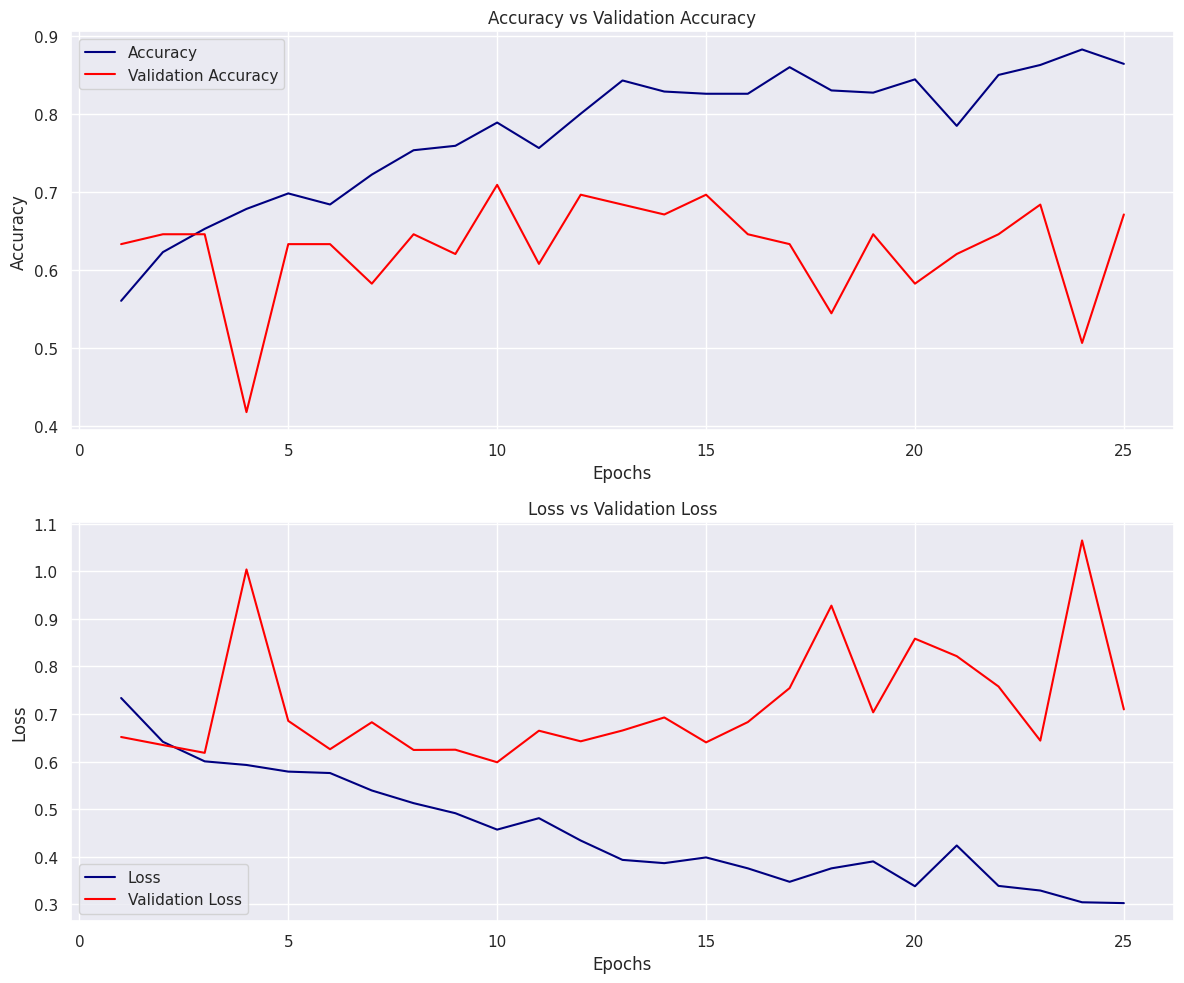

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi yükleme
log_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/cancer/training_3.log', sep=',', engine='python')

# Grafik ayarları
sns.set(rc={'figure.figsize':(11.7, 8.27)})

# Figür ve alt grafikler oluşturma
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Accuracy grafiği
ax1.plot(np.arange(1, len(log_data['accuracy']) + 1, 1), log_data['accuracy'], color='navy', label='Accuracy')
ax1.plot(np.arange(1, len(log_data['val_accuracy']) + 1, 1), log_data['val_accuracy'], color='red', label='Validation Accuracy')
ax1.set_title('Accuracy vs Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss grafiği
ax2.plot(np.arange(1, len(log_data['loss']) + 1, 1), log_data['loss'], color='navy', label='Loss')
ax2.plot(np.arange(1, len(log_data['val_loss']) + 1, 1), log_data['val_loss'], color='red', label='Validation Loss')
ax2.set_title('Loss vs Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Grafikleri gösterme
plt.tight_layout()
plt.show()


# Karşılaştırma matrisi

Eğitilen modelini yükleyip test verisi üzerinde değerlendirme yapar. Yüklenen model ile test verisi üzerinden tahminler yapılır ve bu tahminler belirlenen bir eşik (0.5) kullanılarak ikili sınıflara dönüştürülür. Son olarak, gerçek etiketler ve tahmin edilen etiketler arasındaki karşılaştırmayı göstermek için bir karışıklık matrisi oluşturulur.


Training loss: 0.709753155708313 / Training accuracy: 0.6708860993385315
3/3 ━━━━━━━━━━━━━━━━━━━━ 91s 26s/step


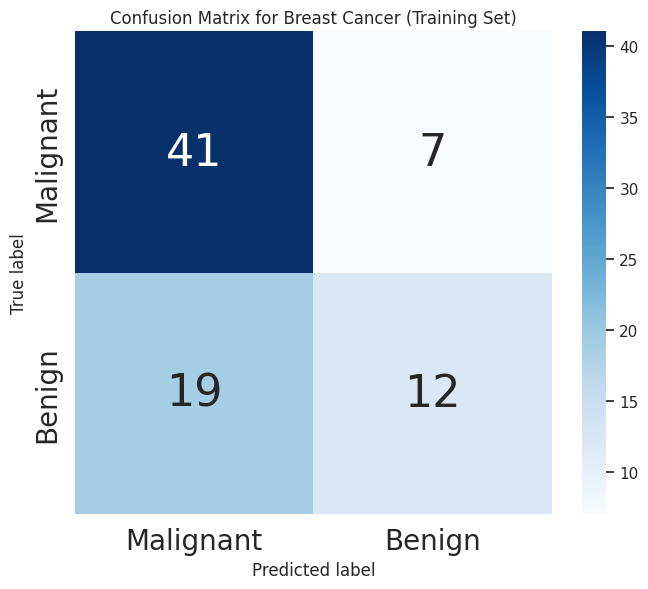

In [25]:
from tensorflow.keras.models import load_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Modeli yükle
VGG_model = load_model('/content/drive/MyDrive/Colab_Notebooks/cancer/first_cancer_model_3.h5')

# Modeli eğitim seti üzerinde değerlendir
score = VGG_model.evaluate(x_test, y_test, verbose=0)
print(f'Training loss: {score[0]} / Training accuracy: {score[1]}')

# Eğitim verisi üzerinde tahmin yap
y_pred_prob_2 = VGG_model.predict(x_test)

# Tahminleri sınıflara dönüştür
threshold = 0.5
y_pred_2 = np.where(y_pred_prob_2 > threshold, 1, 0).squeeze()

# Confusion matrix oluştur
sns.set(rc={'figure.figsize': (7.7, 6.27)})
sns.heatmap(confusion_matrix(y_test, y_pred_2), cmap=plt.cm.Blues, annot=True, annot_kws={"size": 32}, fmt='g')

# Eksenleri ve başlıkları ayarla
plt.xticks([0.50, 1.50], ['Malignant', 'Benign'], fontsize=20)
plt.yticks([0.50, 1.50], ['Malignant', 'Benign'], fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Breast Cancer (Training Set)')

plt.show()


# Manuel test

In [50]:
import cv2
import numpy as np
import pandas as pd
import glob
from tensorflow.keras.models import load_model

# Resim işleme fonksiyonları ve veri yolları zaten tanımlı
def resize_with_padding(image, target_size):
    # Orijinal boyutları al
    h, w = image.shape[:2]

    # Oranı koruyarak yeniden boyutlandırma
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Görüntüyü yeniden boyutlandırma
    resized_image = cv2.resize(image, (new_w, new_h))

    # Yatay ve dikey padding hesaplama
    delta_w = target_size[1] - new_w
    delta_h = target_size[0] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # Kenar dolgu ekleme (padding)
    color = [0, 0, 0]  # Siyah kenarlık
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

def left_or_right(img):
    height, width = img.shape[:2]

    # Görüntüyü ikiye bölme
    left_half = img[:, :width // 2]  # Sol yarı
    right_half = img[:, width // 2:]  # Sağ yarı

    # Piksel yoğunluklarını hesaplama (her bir pikselin parlaklık değerlerinin toplamı)
    left_intensity = np.sum(left_half)
    right_intensity = np.sum(right_half)

    if left_intensity > right_intensity:
        return img

    else:
        img = cv2.flip(img, 1)
        return img

def predict_single_image(model, image_path, true_label):
    # Görüntüyü yükleme ve işleme
    x = image_path.split('/')
    x = f"/content/drive/MyDrive/Colab_Notebooks/cancer/archive/jpeg/{x[2]}/*.jpg"
    x = glob.glob(x)
    x = cv2.imread(x[0])
    x = resize_with_padding(x, (256, 256))
    x = left_or_right(x)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)  # Modelin beklediği boyuta getiriyoruz (1, 256, 256, 3)

    # Tahmin yapma
    prediction_prob = model.predict(x)
    predicted_label = 1 if prediction_prob > 0.5 else 0  # Tahmin edilen sınıfı belirliyoruz

    # Gerçek ve tahmin edilen sonuçları ekrana bas
    if true_label == 1:
        true_label_text = 'Malignant'
    else:
        true_label_text = 'Benign'

    predicted_label_text = 'Malignant' if predicted_label == 1 else 'Benign'

    print(f"Gerçek Sonuç: {true_label_text}")
    print(f"Tahmin Edilen Sonuç: {predicted_label_text}")
    print(f"Tahmin Olasılığı: {prediction_prob[0][0]}")

# CSV dosyasının yolu
dosya_yolu = '/content/drive/MyDrive/Colab_Notebooks/cancer/archive/csv/mass_case_description_test_set.csv'
df = pd.read_csv(dosya_yolu)
rio = df.loc[df["image view"] == "CC", ["image file path", "pathology"]]

# Test setinden rastgele bir örnek seç
sample = rio.sample(1).iloc[0]
image_path = sample["image file path"]
true_label = 1 if sample["pathology"] not in ["BENIGN", "BENIGN_WITHOUT_CALLBACK"] else 0

# Modeli yükle
VGG_model = load_model('/content/drive/MyDrive/Colab_Notebooks/cancer/first_cancer_model_3.h5')

# Tek bir resim üzerinde tahmin yap ve sonucu göster
predict_single_image(VGG_model, image_path, true_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Gerçek Sonuç: Benign
Tahmin Edilen Sonuç: Benign
Tahmin Olasılığı: 0.057043395936489105


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step


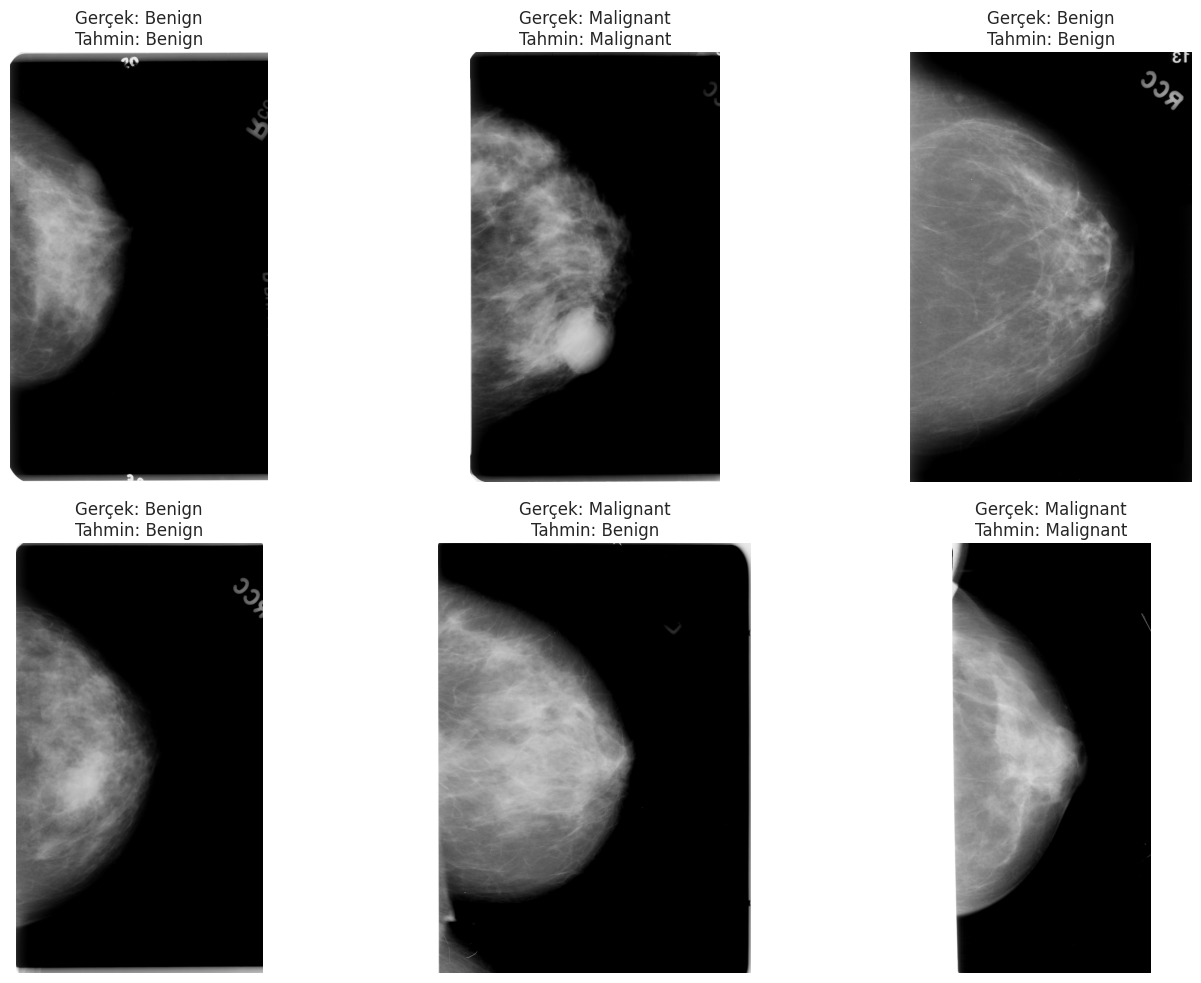

In [59]:
import cv2
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Resim işleme fonksiyonları
def resize_with_padding(image, target_size):
    h, w = image.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w = int(w * scale)
    new_h = int(h * scale)
    resized_image = cv2.resize(image, (new_w, new_h))
    delta_w = target_size[1] - new_w
    delta_h = target_size[0] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    color = [0, 0, 0]
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return padded_image

def left_or_right(img):
    height, width = img.shape[:2]
    left_half = img[:, :width // 2]
    right_half = img[:, width // 2:]
    left_intensity = np.sum(left_half)
    right_intensity = np.sum(right_half)
    return img if left_intensity > right_intensity else cv2.flip(img, 1)

def predict_single_image(model, image_path):
    x = image_path.split('/')
    x = f"/content/drive/MyDrive/Colab_Notebooks/cancer/archive/jpeg/{x[2]}/*.jpg"
    x = glob.glob(x)
    x = cv2.imread(x[0])
    x = resize_with_padding(x, (256, 256))
    x = left_or_right(x)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)
    prediction_prob = model.predict(x)
    predicted_label = 1 if prediction_prob > 0.5 else 0
    return predicted_label, prediction_prob[0][0]

# CSV dosyasının yolu
dosya_yolu = '/content/drive/MyDrive/Colab_Notebooks/cancer/archive/csv/mass_case_description_test_set.csv'
df = pd.read_csv(dosya_yolu)
rio = df.loc[df["image view"] == "CC", ["image file path", "pathology"]]

# Test setinden 6 rastgele örnek seç
samples = rio.sample(6)
# Modeli yükle
VGG_model = load_model('/content/drive/MyDrive/Colab_Notebooks/cancer/first_cancer_model_3.h5')

# Tahmin sonuçlarını ve gerçek değerleri saklamak için listeler
predicted_labels = []
predicted_probs = []
true_labels = []

# Her bir örnek üzerinde tahmin yap
for index, sample in samples.iterrows():

    image_path = sample["image file path"]
    true_label = 1 if sample["pathology"] not in ["BENIGN", "BENIGN_WITHOUT_CALLBACK"] else 0
    predicted_label, predicted_prob = predict_single_image(VGG_model, image_path)

    predicted_labels.append(predicted_label)
    predicted_probs.append(predicted_prob)
    true_labels.append(true_label)

# Grafik oluşturma
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img_path = samples.iloc[i]["image file path"]
    img = img_path.split('/')
    img = f"/content/drive/MyDrive/Colab_Notebooks/cancer/archive/jpeg/{img[2]}/*.jpg"
    img = glob.glob(img)
    img = cv2.imread(img[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = left_or_right(img)
    plt.imshow(img)
    plt.title(f"Gerçek: {'Malignant' if true_labels[i] == 1 else 'Benign'}\nTahmin: {'Malignant' if predicted_labels[i] == 1 else 'Benign'}")
    plt.axis('off')

plt.tight_layout()
plt.show()
